In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
from itertools import combinations

from math import sin, cos, atan2, sqrt, pi
from eda_helpers import normality_check, count_outliers

**1. Start from the Summary coming from the Exploratory Data Analysis (EDA)**

**Summary:**
 - Target: `Price` numerical continuous variable;
 - There are 6 features: 4 continuous, 2 text;
 - There are 3 missing values in target variable;
 - There are no missing values in features;
 - `Price`, `Area` and `Room` have right-skewed distribution and 56, 33, 62 outliers respectively. However if we look closer to these outliers, we'll see that all of them are just big (and thus expencive) houses. These values will not be considered as outliers;
 - There are 2 outiers in `Longitude`, that are much lower than the mean;
 - Outliers of `Latitude` create a cluster togeter with other points and will not be considered as outliers.
 - There is one point, which is an outlier niether for longitude, not for latitude, but when plotting coordinates, we see that it is far from the main distribution of points. It will be considered an outlier;
 - Most values of both text features (`Address` and `Zip`) are unique, thus not informative for prediction;
 - When removing letters from `Zip` code, there are 70 unique values, which represent areas of the city. The assumption is they are more generalized, than original format of zip code.
 

**2. Begin to process the dataset accordingly, e.g., by dealing with missing values, feature engineering and transformation;**

In [2]:
data = pd.read_csv("data/data_train.csv")

data_info = pd.read_csv("data/data_info.csv", index_col=0)
print(f'o Shape of train dataset: {data.shape}')
display(data.sample(3))
print('o Data information')
display(data_info.transpose())
print(f'o Number of duplicate rows that will be removed: {data.duplicated().sum()}')
print(f'o Data type in Dataset: {data_info["data_type"].unique()}')
print(f"o Columns: {data_info.index.tolist()}")

o Shape of train dataset: (739, 7)


,Address,Zip,Price,Area,Room,Lon,Lat
4,"Weesperzijde 114 huis, Amsterdam",1091 EN,1795000.0,158,6,4.912109,52.350755
489,"Tweede Jan van der Heijdenstraat 13, Amsterdam",1073 VE,2650000.0,387,10,4.899350,52.355179
701,"Sophialaan 45, Amsterdam",1075 BM,3500000.0,374,7,4.857608,52.352366


o Data information


,Price,Address,Zip,Area,Room,Lon,Lat
data_type,continuous,text,text,continuous,descrete,continuous,continuous
missing values,3,0,0,0,0,0,0
distribution,right_skewed,not applicable,not applicable,right_skewed,right_skewed,normal,heavy_tailed
n outliers,0,0,0,0,0,3,3


o Number of duplicate rows that will be removed: 1
o Data type in Dataset: ['continuous' 'text' 'descrete']
o Columns: ['Price', 'Address', 'Zip', 'Area', 'Room', 'Lon', 'Lat']


In [3]:
#remove duplicates:
data = data.drop_duplicates()

# remove Longitude outliers (Lon < 4.7)
data.drop(data[data['Lon']< 4.7].index, inplace=True)

# reset indexes after removing rows
data = data.reset_index()
data = data.drop(columns=['index'])
data


,Address,Zip,Price,Area,Room,Lon,Lat
0,"Marcantilaan 123, Amsterdam",1051 LW,325000.0,41,2,4.867459,52.375562
1,"Vossiusstraat 71, Amsterdam",1071 AK,2500000.0,202,6,4.876117,52.359763
2,"Prinsengracht 1035 D, Amsterdam",1017 KP,825000.0,148,3,4.895224,52.361929
3,"Doornburg 155, Amsterdam",1081 JX,699000.0,98,3,4.861985,52.322384
4,"Weesperzijde 114 huis, Amsterdam",1091 EN,1795000.0,158,6,4.912109,52.350755
...,...,...,...,...,...,...,...
731,"Joop Gerritzestraat 14, Amsterdam",1063 EK,500000.0,113,6,4.830151,52.383526
732,"Laan van Vlaanderen 141 A2*, Amsterdam",1066 MP,285000.0,37,2,4.807805,52.344914
733,"Henri Zagwijnstraat 14 3, Amsterdam",1077 XR,685000.0,107,4,4.868754,52.341846
734,"Marnixstraat 237 E, Amsterdam",1015 WE,275000.0,23,1,4.877725,52.376041


**3. For supervised learning, study the relationship between features, a.k.a. independent variables (IV), with the target, a.k.a. the dependent variable (DV).**


- **a.** Study the [correlation](https://www.statisticshowto.com/probability-and-statistics/correlation-analysis/) for both **Discrete** and **Numerical** features.
- **b.** Apply $\chi^{2}$ ([chi-square](https://www.investopedia.com/terms/c/chi-square-statistic.asp)) between two **Nominal** variables;
- **c.** If necessary, transform or construct new features and re-apply the same statistical test;

**!!!** whenever possible, plot the variables to assess whether the results coming from the statistical test are driven by outliers or imbalanced facets;

* Before applying tests it makes sence to fill the missing values:

In [4]:
missing_data = data[data.isna().any(axis=1)]
missing_data

,Address,Zip,Price,Area,Room,Lon,Lat
84,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623
173,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707
180,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877


To determine missing prices it is possible to count average price per square meter (sqm) in the neighbourhood and then multiply it by the house's area:

In [5]:
zips = []

for i in range(missing_data.shape[0]):
    zips.append(list(missing_data['Zip'])[i][:4])

data['Price per sqm'] = data['Price'] / data['Area']

for i in zips:

    #create dataframe with all houses in the neighbourhood
    data_copy = data.loc[data['Zip'].str.contains(i)]
    display(data_copy)

    # get avg price per sqm in the neighbourhood
    mean = data_copy.loc[(data_copy['Zip'].str.contains(i)), 'Price per sqm'].mean()

    #set this value to the row with missing price
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price per sqm'] = mean
    print(f'o Avg Price per sqm in the neighbourhood: {mean}')

    # get area value of the row with missing price
    area = data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Area']

    # set missing price by multiplying average price by size of the house in sqm
    data.loc[(data['Price'].isna()) & (data['Zip'].str.contains(i)), 'Price'] = mean * area
    # display(data.loc[data['Zip'].str.contains(i)])


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
42,"Spaarndammerplantsoen 20, Amsterdam",1013 XT,425000.0,52,2,4.876149,52.390376,8173.076923
84,"Suikerplein 16, Amsterdam",1013 CK,NaN,81,3,4.880976,52.389623,NaN
85,"Martin Vlaarkade 97, Amsterdam",1013 CS,425000.0,75,3,4.881400,52.388529,5666.666667
109,"Haparandaweg 932 A, Amsterdam",1013 BD,500000.0,76,3,4.878134,52.395229,6578.947368
147,"Winthontstraat 28, Amsterdam",1013 BR,525000.0,69,3,4.892282,52.384356,7608.695652
184,"Haarlemmerstraat 98 B, Amsterdam",1013 EW,750000.0,119,6,4.890977,52.380642,6302.521008
247,"Van Noordtkade 140, Amsterdam",1013 CA,335000.0,61,2,4.881952,52.389025,5491.803279
253,"Oostzaanstraat 271, Amsterdam",1013 WJ,375000.0,52,3,4.872555,52.392426,7211.538462
270,"Westerdok 452, Amsterdam",1013 BH,1250000.0,147,4,4.891955,52.385140,8503.401361
372,"Brouwersgracht 182 I, Amsterdam",1013 HC,500000.0,72,2,4.887619,52.381092,6944.444444


o Avg Price per sqm in the neighbourhood: 7194.066645286559


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
2,"Prinsengracht 1035 D, Amsterdam",1017 KP,825000.0,148,3,4.895224,52.361929,5574.324324
67,"Lange Leidsedwarsstraat 103 1 A, Amsterdam",1017 NJ,375000.0,38,1,4.886109,52.363042,9868.421053
72,"Amstel 124 B, Amsterdam",1017 AD,575000.0,70,2,4.897782,52.366928,8214.285714
165,"Bakkersstraat 11, Amsterdam",1017 CW,650000.0,81,3,4.897432,52.366729,8024.691358
173,"Falckstraat 47 A, Amsterdam",1017 VV,NaN,147,3,4.897454,52.360707,NaN
181,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
217,"Maarten Jansz. Kosterstraat 10, Amsterdam",1017 VX,650000.0,67,4,4.901713,52.360545,9701.492537
243,"Lange Leidsedwarsstraat 103 1 B, Amsterdam",1017 NJ,399000.0,40,2,4.886109,52.363042,9975.000000
250,"Utrechtsedwarsstraat 4, Amsterdam",1017 WG,1700000.0,194,6,4.896542,52.360937,8762.886598
252,"Lange Leidsedwarsstraat 95 C, Amsterdam",1017 NH,475000.0,58,3,4.885902,52.363158,8189.655172


o Avg Price per sqm in the neighbourhood: 9698.018857575895


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
52,"Gerda Brautigamstraat 37, Amsterdam",1067 VM,545000.0,110,4,4.789083,52.379219,4954.545455
133,"Hendrik Bulthuisstraat 8, Amsterdam",1067 SC,345000.0,69,4,4.795948,52.374337,5000.000000
154,"Sam van Houtenstraat 191 C, Amsterdam",1067 JG,375000.0,94,4,4.800745,52.379133,3989.361702
180,"Haarlemmerweg 705, Amsterdam",1067 HP,NaN,366,12,4.787874,52.383877,NaN
223,"Willem Kromhoutstraat 17, Amsterdam",1067 RC,380000.0,77,4,4.795007,52.375474,4935.064935
231,"J.G. Suurhoffstraat 123, Amsterdam",1067 VR,425000.0,102,4,4.789341,52.380775,4166.666667
339,"Van Karnebeekstraat 7, Amsterdam",1067 RG,375000.0,69,4,4.799561,52.374310,5434.782609
401,"Pieter van der Werfstraat 44, Amsterdam",1067 EP,380000.0,100,4,4.802560,52.380679,3800.000000
402,"Philip Vingboonsstraat 19, Amsterdam",1067 BG,375000.0,84,4,4.795800,52.383180,4464.285714
479,"Teldershof 57, Amsterdam",1067 ML,350000.0,88,3,4.800286,52.380052,3977.272727


o Avg Price per sqm in the neighbourhood: 4393.697769166612


In [6]:
display(data[data.isna().any(axis=1)])

,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm


In [7]:
# Add info about 'Price per sqm'
data_info.loc['Price per sqm', 'data_type'] = 'continuous'
data_info.loc['Price per sqm', 'missing values'] = 0
normality_check(data, data_info, ['Price per sqm'])
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,not normal,NaN


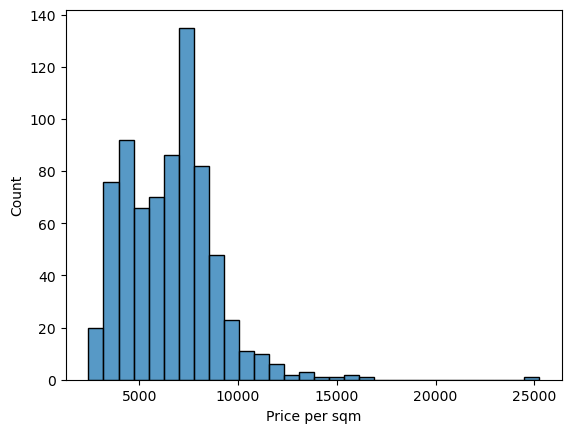

In [8]:
# plot 'Price per sqm' distribution as a histplot
plot = sns.histplot(x = data['Price per sqm'], bins = 30)

**Distribution is right-skewed**

In [9]:
data_info.loc['Price per sqm', 'distribution'] = 'right_skewed'

In [10]:
#Check outliers of Price per sqm
count_outliers(data = data, data_info = data_info, features = ['Price per sqm'], show_details = True)

o 10 datapoints with Price per sqm > 12484.237438861717


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm
14,"Nieuwe Keizersgracht 570 L, Amsterdam",1018 VG,1050000.0,63,3,4.908850,52.365524,16666.666667
100,"Pieter Cornelisz. Hooftstraat 169 B, Amsterdam",1071 BW,1695000.0,117,3,4.876144,52.358928,14487.179487
137,"Prins Hendrikkade 512, Amsterdam",1011 TE,389000.0,30,2,4.906059,52.374085,12966.666667
181,"Amstel 102, Amsterdam",1017 AD,2325000.0,150,6,4.896842,52.366965,15500.000000
196,"Dam 5 V, Amsterdam",1012 JS,4495000.0,178,5,4.894290,52.373106,25252.808989
323,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,3,4.897473,52.358943,13524.590164
383,"Leonard Bernsteinstraat 96 A, Amsterdam",1082 MR,1750000.0,130,3,4.872151,52.336348,13461.538462
468,"Keizersgracht 544, Amsterdam",1017 EL,5950000.0,394,10,4.887378,52.365078,15101.522843
707,"Diemerzeedijk 76 S, Amsterdam",1087 SM,400000.0,25,2,4.962333,52.362891,16000.000000
710,"Huidekoperstraat 24 F, Amsterdam",1017 ZM,2475000.0,183,4,4.897473,52.358943,13524.590164


The biggest outlier is a house, located on a Dam square, which is the most famous square of Amsterdam, so it is normal, that it is so expencive. Besides that, according to google maps, this house is a new-build or recently renovated. All other houses in outliers list are mostly located in the city center or next to tourist attractions (like row 100 - next to Vondelpark). However row 710 looks weird. That is 25 sqm with 2 rooms and 16k per sqm. According to google maps, that is just a garage for a boat. This datapoint might be a mistake and will be added to list of outliers.

In [11]:
data_info.loc['Price per sqm', 'n outliers'] = 1

In [12]:
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0


**a. Study correlations between numerical features:**

As in this dataset most of variables are not distributed normally, we have to create a function, that will dicide if Pearson's or Spearman's correlation test has to be applied:

In [13]:
def custom_corr(data: pd.DataFrame, data_info: pd.DataFrame) -> pd.DataFrame:
    """ Calculate the correlations between all possible pairs of numerical data features depending on their distributions.

    Args:
        data: pd.DataFrame
            dataframe with features
        data_info: pd.DataFrame
            dataframe with information about distribution of data features

    Returns:
        summary: pd.DataFrame: 
            dataframe with the following information about correlations: 
             - method: Pearson or Spearman
             - feature1 and feature2
             - r-value: correlation coefficient
             - p-value: how signifficant is that correlation. 
             - stat-sign: bool. Significance theshold is p-value = 0.05, so 0.04 is significant, 0.06 - not.
             - N: number of observations in each feature.
    """
    summary = pd.DataFrame()
    
    # create lists with normaly / not normaly distributed features
    norm_features = []
    no_norm_features = []
    for i in data.columns:
        if (data_info.loc[i, 'data_type'] == 'continuous') or (data_info.loc[i, 'data_type'] == 'descrete') :
            if data_info.loc[i, 'distribution'] == 'normal':
                norm_features.append(i)
            else:
                no_norm_features.append(i)

    # create list of all possible combinations of features without repeats
    iterator = combinations(norm_features+no_norm_features, 2)

    # get correlations between every pait of features and it's signifficance
    for col1, col2 in iterator:
        if col1 in norm_features and col2 in norm_features:
            r_value, p_value = stats.pearsonr(data.loc[:, col1], data.loc[:, col2])
            method = 'Pearson'
        else: 
            r_value, p_value = stats.spearmanr(data.loc[:, col1], data.loc[:, col2])
            method = 'Spearman'
        n = len(data)

        # Store output in dataframe format
        dict_summary = {
            "method": method,
            "feature1": col1,
            "feature2": col2,
            "r-value": r_value,
            "p-value": p_value,
            "stat-sign": (p_value < 0.05),
            "N": n,
        }
        summary = pd.concat(
            [summary, pd.DataFrame(data=dict_summary, index=[0])],
            axis=0,
            ignore_index=True,
            sort=False,
        )
    return summary


In [14]:
correlations_df = custom_corr(data, data_info)
correlations_df

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman,Lon,Price,-0.042635,2.480050e-01,False,736
1,Spearman,Lon,Area,0.052285,1.564759e-01,False,736
2,Spearman,Lon,Room,0.000793,9.828690e-01,False,736
3,Spearman,Lon,Lat,-0.050452,1.715436e-01,False,736
4,Spearman,Lon,Price per sqm,-0.094214,1.054892e-02,True,736
5,Spearman,Price,Area,0.730393,1.208428e-123,True,736
6,Spearman,Price,Room,0.524469,2.998640e-53,True,736
7,Spearman,Price,Lat,0.050838,1.682803e-01,False,736
8,Spearman,Price,Price per sqm,0.456403,3.787774e-39,True,736
9,Spearman,Area,Room,0.761115,3.858506e-140,True,736


As we can see here, most of statistically signifficant correlations are between a feature and a target (in this case there are 2 targets: price and price per sqm). Longitude and Latitude have no impact on price, however both have impact on price per sqm. Also there is positive correlation between Area and Rooms which seems to be fair. This features might be transformed later.

**Haversine formula** to calculate distance from the city center:

a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)

c = 2 ⋅ atan2( √a, √(1−a) )

d = R ⋅ c

where	φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);

In [15]:
# φ, λ in radians

lat_center = data['Lat'].mean() * pi/180
lon_center = data['Lon'].mean() * pi/180

R = 6371e3 # in meters
data['Distance from center, m'] = np.nan

for row in range(len(data)):
    point_lat = data.loc[row, 'Lat'] * pi/180
    point_lon = data.loc[row, 'Lon'] * pi/180
    delta_lat = abs(point_lat - lat_center)
    delta_lon = abs(point_lon - lon_center)

    a = np.square(sin(delta_lat/2)) + cos(point_lat) * cos(lat_center) * np.square(sin(delta_lon/2))
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c
    data.loc[row, 'Distance from center, m'] = int(d)  

In [16]:
# show the 5 most central houses
nearest = list(data['Distance from center, m'].nsmallest(5))
data.loc[data['Distance from center, m'].isin(nearest), :]

,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,"Distance from center, m"
67,"Lange Leidsedwarsstraat 103 1 A, Amsterdam",1017 NJ,375000.0,38,1,4.886109,52.363042,9868.421053,225.0
243,"Lange Leidsedwarsstraat 103 1 B, Amsterdam",1017 NJ,399000.0,40,2,4.886109,52.363042,9975.000000,225.0
510,"Vijzelstraat 91, Amsterdam",1017 HH,1185000.0,160,5,4.892374,52.363383,7406.250000,201.0
651,"Tweede Weteringdwarsstraat 44 2, Amsterdam",1017 SX,325000.0,44,3,4.889549,52.361331,7386.363636,209.0
652,"Keizersgracht 515 R, Amsterdam",1017 DN,935000.0,85,3,4.888700,52.365003,11000.000000,204.0


In [17]:
# add info about new feature
data_info.loc['Distance from center, m', 'missing values'] = 0
data_info.loc['Distance from center, m', 'data_type'] = 'continuous'
normality_check(data, data_info, ['Distance from center, m'])
data_info

,data_type,missing values,distribution,n outliers
Price,continuous,3.0,right_skewed,0.0
Address,text,0.0,not applicable,0.0
Zip,text,0.0,not applicable,0.0
Area,continuous,0.0,right_skewed,0.0
Room,descrete,0.0,right_skewed,0.0
Lon,continuous,0.0,normal,3.0
Lat,continuous,0.0,heavy_tailed,3.0
Price per sqm,continuous,0.0,right_skewed,1.0
"Distance from center, m",continuous,0.0,not normal,NaN


<Axes: xlabel='Distance from center, m', ylabel='Count'>

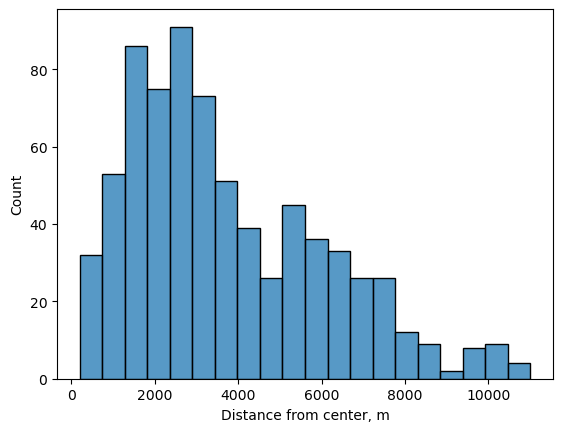

In [18]:
# plot 'Distance from center' distribution as a histplot
sns.histplot(data['Distance from center, m'], bins = 20)

In [19]:
data_info.loc['Distance from center, m', 'distribution'] = 'right_skewed'

In [20]:
# Check if there are any outliers in 'Distance from center, m' 
count_outliers(data = data, data_info = data_info, features = ['Distance from center, m'], show_details = True)

o 2 datapoints with Distance from center, m > 10727.75


,Address,Zip,Price,Area,Room,Lon,Lat,Price per sqm,"Distance from center, m"
427,"Dorpsstraat Holysloot 62, Amsterdam",1028 BE,1495000.0,214,5,5.029122,52.413550,6985.981308,11009.0
512,"Lange Stammerdijk 1 G, Amsterdam",1109 BK,549001.0,107,4,5.016522,52.305075,5130.850467,10788.0


Point 427 was also considered an outlier during EDA in step 